### 1. DB에서 필요한 데이터들 불러오기

In [5]:
import pymysql
import pandas as pd

In [145]:
con = pymysql.connect(
    host='localhost',
    user='root',
    password='1111',
    db='beaulol',
    charset='utf8'
)

customer_type_df = pd.read_sql("SELECT userID, user_skintype,user_trouble FROM customer_type", con)
customer_regis_df = pd.read_sql("SELECT userID, prd_brand, prd_name FROM customer_regis", con)
product_info_df = pd.read_sql("SELECT prd_name, prd_brand, prd_ingredients, prd_category FROM product_info", con)
solvent_df = pd.read_sql("SELECT ingredient_kor FROM solvent", con)

con.close()

C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\896438246.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_type_df = pd.read_sql("SELECT userID, user_skintype,user_trouble FROM customer_type", con)
C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\896438246.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_regis_df = pd.read_sql("SELECT userID, prd_brand, prd_name FROM customer_regis", con)
C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\896438246.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy

In [146]:
customer_type_df.head()

,userID,user_skintype,user_trouble
0,F0002,건성,민감성/아토피
1,F0003,복합성,주름/탄력
2,F0004,중성,잡티/미백/홍조/다크서클
3,F0005,건성,각질
4,F0006,중성,트러블


In [147]:
customer_regis_df.head()

,userID,prd_brand,prd_name
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼
2,F0002,라운드랩,1025 독도 토너
3,F0002,아벤느,트릭세라 로션
4,F0002,에스트라,아토베리어365 하이드로 수딩크림


In [148]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"정제수, 나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, ...",세럼
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1,2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1,2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너


### 2. 전처리
    [콤마 포함한 성분 이름 변경]
    1) 모든 '화장품 원료'(from 화장품원료.csv) 중에 콤마가 들어가 성분 추출
    2) product_info_df안에 콤마포함성분 확인 -> 4가지 성분 확인
    3) 콤마포함성분을 슬래시로 변경

----
    [구분자 변경 & 괄호 제거]
    우선 (콤마 스페이스, 콤마, 스페이스)로 나눠진 데이터가 가장 많다. 하지만 스페이스와 콤마는 후에 성분내에 ex) 레티놀 (500IU/g), 쏼라쏼라(100,000ppm) 콤마와 스페이스를 넣어놓은 곳이 있기 때문에 나중에 세부 처리.
    1) 이 세 구분자를 제외한 구분자 모두 콤마 스페이스(, )로 변경
    2) 성분뒤 괄호안 내용 다 제거 (정규표현식 이용)

    3) 콤마스페이스로 구분되지않은 nd_product_info_df 생성 >> 81행 발견
    이유: 스페이스나 콤마로 구분자가 많아서 그렇다.
    4) 콤마나 스페이스 구분자를, 콤마 스페이스 구분자로 변경 
    5) 그래도 이상한 이상치들 확인. 15개 성분데이터는 '-'대시로 변경하여 머신러닝 영향을 최소화
    6) nd_product_info_df 를 원본 데이터프레임과 합침.

    product_info_df의 전처리 끝
------
    [용매와 방부제 역할을 하는 성분 제거 후, 새로운 열 'main_prd_ingredients' 생성]
    1) solvent df에서 성분안에 콤마를 가진 성분 슬래쉬로 변경후, 리스트로 정리
    2) solvent 성분을 'prd_ingredients'에서 제거후, 'main_prd_ingredients'에 저장
-----
    [유저별 화장품 목록, 화장품 성분 목록 생성]
    - 유저별로 화장품 목록과 화장품 성분목록을 묶어서 만든 뒤, 최종 셋팅 완료된 데이터를 csv 파일로 저장.

In [149]:
'''
구분자 종류:
1) 스페이스바( )
2) 콤마 스페이스(, )
3) 콤마(,)
3) 온점 스페이스(. )
4) 골뱅이(@)
5) 별 콤마(*.)
6) 별 골뱅이(*@)
7) 별 (*)
'''

'\n구분자 종류:\n1) 스페이스바( )\n2) 콤마 스페이스(, )\n3) 콤마(,)\n3) 온점 스페이스(. )\n4) 골뱅이(@)\n5) 별 콤마(*.)\n6) 별 골뱅이(*@)\n7) 별 (*)\n'

- 1) 콤마 포함 성분 이름 변경

In [150]:
# 모든 성분들 이름 불러오기
all_ingred = pd.read_csv('./files/화장품원료.csv')
all_ingred.head()

,INGR_KOR_NAME,INGR_ENG_NAME,CAS_NO,ORIGIN_MAJOR_KOR_NAME,INGR_SYNONYM
0,가공소금,NaN,NaN,NaN,NaN
1,가지열매추출물,Solanum Melongena (Eggplant) Fruit Extract,84012-19-1,이 원료는 가지(Eggplant) Solanum melongena의 열매에서 추출한...,가지추출물
2,구멍쇠미역추출물,Agarum Cribrosum Extract,NaN,이 원료는 조류의 일종인 구멍쇠미역 Agarum cribosum에서 추출한 것이다.,NaN
3,루핀아미노산,Lupine Amino Acids,NaN,이 원료는 루핀 단백질의 완전 가수분해로 얻은 아미노산의 혼합물이다.,NaN
4,류신,Leucine,"328-39-2(DL-)\r,61-90-5(L-)",이 원료는 다음의 구조를 갖는 아미노산이다.,NaN


In [151]:
# 콤마를 가진 성분들 저장하기
comma_inged = all_ingred[all_ingred['INGR_KOR_NAME'].str.contains(',')==True]['INGR_KOR_NAME']
comma_inged.head()

629                5-브로모-5-나이트로-1,3-디옥산
630              2-브로모-2-나이트로프로판-1,3-디올
2035                  에틸2,2-다이메틸하이드로신남알
2524    4,4'-아이소프로필리덴다이페놀/에피클로로하이드린코폴리머
3666                         1,10-데칸다이올
Name: INGR_KOR_NAME, dtype: object

In [152]:
# 콤마 포함된 성분들
for x in comma_inged:
    matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]
    if not matching_rows.empty:
        print(x)
        display(matching_rows)
# 결과: 4개의 성분이 성분들 나누기를 방해하고 있다.
# 1,2-헥산다이올, 2-올레아미도-1,3-옥타데칸다이올, 2,3-부탄다이올, 2,4-다이메틸-3-사이클로헥신카복스알데하이드

1,2-헥산다이올


,prd_name,prd_brand,prd_ingredients,prd_category
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1,2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1,2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너
5,3번 결광가득 에센스 토너,넘버즈인,"정제수, 다이프로필렌글라이콜, 글리세레스-26, 1,2-헥산다이올, 나이아신아마이드...",스킨토너
...,...,...,...,...
432,히알루로닉 에센스,로벡틴,"정제수, 글리세린, 메틸글루세스-20, 펜틸렌글라이콜, 부틸렌글라이콜, 나이아신아마...",세럼
433,히알루론산 레이어 물톡스 앰플,메디필,"정제수, 프로판다이올, 글리세린, 다이프로필렌글라이콜, 메틸프로판다이올, 1,2-헥...",세럼
434,히알루론산 레이어 물톡스 앰플 더블 기획,메디필,"정제수, 프로판다이올, 글리세린, 다이프로필렌글라이콜, 메틸프로판다이올, 1,2-헥...",세럼
435,힐러 턴오버 액티브 크림,리쥬란,"정제수, 글리세린, 부틸렌글라이콜, 메틸하이드로제네이티드로지네이트, 다이프로필렌글라...",크림


2-올레아미도-1,3-옥타데칸다이올


,prd_name,prd_brand,prd_ingredients,prd_category
183,비오템옴므 아쿠아파워 어드밴스드 젤 로션 100ML,비오템 옴므,정제수 다이메티콘 변성알코올 글리세린 부틸렌글라이콜 시어버터 암모늄폴리아크릴로일다이...,로션


2,3-부탄다이올


C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\1074179305.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]


,prd_name,prd_brand,prd_ingredients,prd_category
39,노스카나인 트러블 클리어 토너,파티온,"정제수, 2,3-부탄다이올, 에톡시다이글라이콜, 글루코노락톤, 1,2-헥산다이올, ...",스킨토너
43,다이브인 저분자 히알루론산 수딩 크림,토리든,"정제수, 부틸렌글라이콜, 글리세린, 1,2-헥산다이올, 하이드로제네이티드다이데센, ...",크림
45,다이브인 저분자 히알루론산 토너,토리든,"정제수, 부틸렌글라이콜, 다이프로필렌글라이콜, 1,2-헥산다이올, 글리세린, 베타인...",스킨토너
58,데일리뮨 앰플 세럼,피지오겔,"정제수, 다이프로필렌글라이콜, 프로판다이올, 아스코빅애씨드, 2,3-부탄다이올, 글...",세럼
71,레드 블레미쉬 클리어 모이스처 크림,닥터지,"정제수, 글리세린, 2,3-부탄다이올, 하이드로제네이티드폴리(C6-14올레핀), 병...",크림
109,리큐어 노르데나우 시카에센스,케어존,"정제수, 글리세린, 2,3-부탄다이올, 사이클로펜타실록세인, 다이메티콘, 1,2-헥...",세럼
118,마이크로액티브 브라이트닝 앰플,숨37,"정제수*, 글리세린, 부틸렌글라이콜*, 소듐아스코빌포스페이트*, 2,3-부탄다이올*...",세럼
119,마이크로액티브 카밍 앰플,숨37,"정제수*, 변성알코올, 2,3-부탄다이올*, 글리세린*, 세린*, 1,2-헥산다이올...",세럼
140,미라클 토닝 글로우 세럼,오휘,"정제수, 프로판다이올, 글리세린, 2,3-부탄다이올, 펜틸렌글라이콜, 나이아신아마이...",세럼
196,사이언수티컬즈 데일리뮨 앰플세럼,피지오겔,"정제수, 다이프로필렌글라이콜, 프로판다이올, 아스코빅애씨드, 2,3-부탄다이올, 글...",세럼


2,4-다이메틸-3-사이클로헥신카복스알데하이드


C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\1074179305.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]


,prd_name,prd_brand,prd_ingredients,prd_category
29,그린토마토 포어 리프팅 앰플 플러스,성분에디터,"정제수, 부틸렌글라이콜, 글리세린, 자일리톨, 1,2-헥산다이올, 나이아신아마이드,...",세럼


C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\1074179305.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]


In [153]:
# 4개 성분 이름 안 콤마를 슬래쉬(/)로 변경
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('1,2-헥산다이올', '1/2-헥산다이올')
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('2-올레아미도-1,3-옥타데칸다이올', '2-올레아미도-1/3-옥타데칸다이올')
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('2,3-부탄다이올', '2/3-부탄다이올')
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('2,4-다이메틸-3-사이클로헥신카복스알데하이드', '2/4-다이메틸-3-사이클로헥신카복스알데하이드')

* 2. 구분자 변경 & 괄호 제거

In [154]:
# 우선 구분자 수정> ', '로
import re
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x: re.sub(r'\. |@|\*\.|\*,|\*@|\*', ', ', x))

# nd_product_info_df['prd_ingredients'] = nd_product_info_df['prd_ingredients'].str.replace('. ', ', ').str.replace('@', ', ').str.replace('*.', ', ').str.replace('*,',', ').str.replace('*@', ', ')

In [155]:
# 'prd_ingredients' 열의 문자열에서 괄호와 괄호 안의 내용을 제거

product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x:\
    re.sub(r'\(.*?\)', '', x))

In [156]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"정제수, 나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, ...",세럼
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너


In [157]:
# 콤마 스페이스로 구분 되지 않는 것들
nd_product_info_df = product_info_df[product_info_df['prd_ingredients'].str.split(', ').apply(len) == 1]

display(product_info_df[product_info_df['prd_ingredients'].str.split(', ').apply(len) == 1])
nd_product_info_df.info()
# 81개의 행이 이상.. 스페이스와 콤마로만 구분하는 구분자 존재. 

# product_info_df[len(product_info_df['prd_ingredients'].str.split(','))==1]
# 오류나는 이유??

,prd_name,prd_brand,prd_ingredients,prd_category
20,NEW 시카플라스트 밤B5+,라로슈포제,정제수 하이드로제네이티드폴리아이소부텐 다이메티콘 글리세린 시어버터 판테놀 옥수수전분...,크림
23,갈락토미세스 발효 에센스,믹순,갈락토미세스발효여과물 100%,세럼
35,나이아신아마이드+모과추출물 세럼,마리엔메이,"모과추출물,글리세레스-26,나이아신아마이드,1/2-헥산다이올,알지닌,카보머,에틸헥실...",세럼
36,낫츠 센텔라스카 연고 일랑일랑 15g,낫츠,-,크림
44,다이브인 저분자 히알루론산 크림,토리든,화장품법에 따라 기재해야 하는 모든 성분,크림
...,...,...,...,...
413,하이드라 크림 앰플 더블 기획,나인위시스,-하이드라 크림앰플,세럼
421,하이알루론 부스팅에센스,유세린,"정제수,변성알코올,글리세린,부틸렌글라이콜,판테놀,피이지-40하이드로제네이티드캐스터오...",세럼
423,허니 세럼,아임프롬,"글리세린,정제수,부틸렌글라이콜,다이메티콘,사이클로펜타실록세인,나이아신아마이드,피이지...",세럼
428,히아루론산 토너 더블 기획,이즈앤트리,"정제수,프로판다이올,1/2-헥산다이올,소듐하이알루로네이트,트레할로오스,소듐피씨에이,...",스킨토너


<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 20 to 430
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prd_name         81 non-null     object
 1   prd_brand        81 non-null     object
 2   prd_ingredients  81 non-null     object
 3   prd_category     81 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB


In [158]:
# nd_product_info_df.to_csv('./files/콤마나 스페이스로 처리전 데이타.csv',encoding='cp949')

In [159]:
# 스페이스나 콤마 > 콤마 스페이스로 변경
nd_product_info_df['prd_ingredients'] = nd_product_info_df['prd_ingredients'].apply(lambda x: re.sub(r' |,',', ',x))

C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\623909897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nd_product_info_df['prd_ingredients'] = nd_product_info_df['prd_ingredients'].apply(lambda x: re.sub(r' |,',', ',x))


In [160]:
nd_product_info_df

,prd_name,prd_brand,prd_ingredients,prd_category
20,NEW 시카플라스트 밤B5+,라로슈포제,"정제수, 하이드로제네이티드폴리아이소부텐, 다이메티콘, 글리세린, 시어버터, 판테놀,...",크림
23,갈락토미세스 발효 에센스,믹순,"갈락토미세스발효여과물, 100%",세럼
35,나이아신아마이드+모과추출물 세럼,마리엔메이,"모과추출물, 글리세레스-26, 나이아신아마이드, 1/2-헥산다이올, 알지닌, 카보머...",세럼
36,낫츠 센텔라스카 연고 일랑일랑 15g,낫츠,-,크림
44,다이브인 저분자 히알루론산 크림,토리든,"화장품법에, 따라, 기재해야, 하는, 모든, 성분",크림
...,...,...,...,...
413,하이드라 크림 앰플 더블 기획,나인위시스,"-하이드라, 크림앰플",세럼
421,하이알루론 부스팅에센스,유세린,"정제수, 변성알코올, 글리세린, 부틸렌글라이콜, 판테놀, 피이지-40하이드로제네이티...",세럼
423,허니 세럼,아임프롬,"글리세린, 정제수, 부틸렌글라이콜, 다이메티콘, 사이클로펜타실록세인, 나이아신아마이...",세럼
428,히아루론산 토너 더블 기획,이즈앤트리,"정제수, 프로판다이올, 1/2-헥산다이올, 소듐하이알루로네이트, 트레할로오스, 소듐...",스킨토너


In [161]:
# nd_product_info_df.to_csv('./files/이상치 봐.csv', encoding='cp949')

In [162]:
# 아예 이상치 15개 성분 데이터는 prd_ingredients에 대시로 변경
remove_index = [36,44,146,147,236,237,240,278,312,326,327,349,401,413,430]

for i in remove_index:
    nd_product_info_df.loc[i,'prd_ingredients'] = '-'
nd_product_info_df

,prd_name,prd_brand,prd_ingredients,prd_category
20,NEW 시카플라스트 밤B5+,라로슈포제,"정제수, 하이드로제네이티드폴리아이소부텐, 다이메티콘, 글리세린, 시어버터, 판테놀,...",크림
23,갈락토미세스 발효 에센스,믹순,"갈락토미세스발효여과물, 100%",세럼
35,나이아신아마이드+모과추출물 세럼,마리엔메이,"모과추출물, 글리세레스-26, 나이아신아마이드, 1/2-헥산다이올, 알지닌, 카보머...",세럼
36,낫츠 센텔라스카 연고 일랑일랑 15g,낫츠,-,크림
44,다이브인 저분자 히알루론산 크림,토리든,-,크림
...,...,...,...,...
413,하이드라 크림 앰플 더블 기획,나인위시스,-,세럼
421,하이알루론 부스팅에센스,유세린,"정제수, 변성알코올, 글리세린, 부틸렌글라이콜, 판테놀, 피이지-40하이드로제네이티...",세럼
423,허니 세럼,아임프롬,"글리세린, 정제수, 부틸렌글라이콜, 다이메티콘, 사이클로펜타실록세인, 나이아신아마이...",세럼
428,히아루론산 토너 더블 기획,이즈앤트리,"정제수, 프로판다이올, 1/2-헥산다이올, 소듐하이알루로네이트, 트레할로오스, 소듐...",스킨토너


In [163]:
# nd_product_info_df를 사용하여 원본 데이터프레임을 업데이트
# nd_product_info_df에 있는 모든 인덱스에 해당하는 행의 'prd_ingredients' 값을 대체

for idx in nd_product_info_df.index:
    product_info_df.at[idx, 'prd_ingredients'] = nd_product_info_df.at[idx, 'prd_ingredients']

# product_info_df.iloc[183]


In [164]:
# 완벽한 데이터셋 준비 끝
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"정제수, 나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, ...",세럼
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너


In [1]:
# 정제수 포함 하기라도 하면 다 제거해라. (■ 정제수, 혹은 정제수,로 연결된 것)
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x: ', '.join([ingredient.strip() for \
    ingredient in x.split(', ') if '정제수' not in ingredient]))


NameError: name 'product_info_df' is not defined

---

In [73]:
product_info_df = pd.read_excel('./data/02.클러스터링데이터전처리_final.xlsx',index_col=0)
product_info_df

,prd_name,prd_brand,prd_ingredients,prd_category,main_prd_ingredients
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, 포스포리피...",세럼,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 포스포리피드, 소듐하이알루..."
1,1025 독도 로션,라운드랩,"글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터, 아이리...",로션,"퀸즈랜드넛오일, 호호바에스터, 아이리쉬모스추출물, 사탕수수추출물, 해수, 하이알루로..."
2,1025 독도 토너,라운드랩,"부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물, 사탕수...",스킨토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,"11년간, 1등 잡티세럼",아이소이,"다마스크장미꽃수, 글리세린, 에탄올, 알부틴, 베타인, 트레할로오스, 다마스크장미꽃...",세럼,"다마스크장미꽃수, 에탄올, 알부틴, 베타인, 트레할로오스, 다마스크장미꽃오일, 비타..."
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 프로판다이올, 부틸렌글라이콜, 히아신스전..."
...,...,...,...,...,...
432,히알루로닉 에센스,로벡틴,"글리세린, 메틸글루세스-20, 펜틸렌글라이콜, 부틸렌글라이콜, 나이아신아마이드, 솔...",세럼,"메틸글루세스-20, 나이아신아마이드, 솔비톨, 아데노신, 카페인, 소듐하이알루로네이..."
433,히알루론산 레이어 물톡스 앰플,메디필,"프로판다이올, 글리세린, 다이프로필렌글라이콜, 메틸프로판다이올, 1/2-헥산다이올,...",세럼,"나이아신아마이드, 다시마추출물, 한련초잎추출물, 병풀뿌리추출물, 에난티아 클로란타껍..."
434,히알루론산 레이어 물톡스 앰플 더블 기획,메디필,"프로판다이올, 글리세린, 다이프로필렌글라이콜, 메틸프로판다이올, 1/2-헥산다이올,...",세럼,"나이아신아마이드, 다시마추출물, 한련초잎추출물, 병풀뿌리추출물, 에난티아 클로란타껍..."
435,힐러 턴오버 액티브 크림,리쥬란,"글리세린, 부틸렌글라이콜, 메틸하이드로제네이티드로지네이트, 다이프로필렌글라이콜, 다...",크림,"메틸하이드로제네이티드로지네이트, 다이스타치포스페이트, 다이카프릴릴카보네이트, 세테아..."


* 3. 용매와 방부제 제거후, 핵심 성분열 저장

In [171]:
# 솔벤트도 한 성분내에 콤마있을경우, 슬래시로 변경
solvent_df['ingredient_kor'] = solvent_df['ingredient_kor'].str.replace(',','/')

# 솔벤트 리스트 정의
solvent_lst = solvent_df['ingredient_kor'].tolist()
solvent_lst

['사이클로테트라실록세인',
 '테트라데센',
 '메틸트라이메티콘',
 '옥타데케인',
 '피이지-18',
 '사이클로헥사실록세인',
 '피이지/피피지-6/2코폴리머',
 '에틸에터',
 '헥산다이올',
 '다이부틸아디페이트',
 '다이메틸아이소소바이드',
 '하이드로제네이티드폴리데센',
 '피피지-55글리세릴에터',
 '퍼플루오로퍼하이드로페난트렌',
 '아이소옥탄',
 '퍼플루오로다이메틸사이클로헥산',
 '페녹시프로판다이올',
 '다이옥솔레인',
 '사이클로펜타실록세인',
 '3-메톡시부탄올',
 '트라이부틸시트레이트',
 '상어간오일',
 '다이에틸옥살레이트',
 '헥실렌글라이콜',
 '다이에톡시에틸석시네이트',
 '에틸아세테이트',
 '트라이아세틴',
 '트라이에틸포스페이트',
 '벤질벤조에이트',
 '프로필렌글라이콜부틸에터',
 '다이메틸석시네이트',
 '엠이케이',
 '글리세레스-18벤조에이트',
 '자일렌',
 '펜타플루오로프로판',
 '메톡시아이소프로판올',
 '스쿠알렌',
 '다이아이소옥틸아디페이트',
 '피피지-3',
 'C16-17알킬벤조에이트',
 '미비케이',
 'C10-12알케인/사이클로알케인',
 '사이클로헥산온',
 '다이-피피지-3미리스틸에터아디페이트',
 '피이지/피피지-200/70코폴리머',
 'C14-19알케인',
 '톨루엔',
 '솔베스-30',
 '테트라하이드로퍼퓨릴아세테이트',
 'C10-18트라이글리세라이즈',
 '다이에틸세바케이트',
 '다이부틸옥살레이트',
 '아이소부틸벤조에이트',
 '퍼플루오로데칼린',
 '옥틸도데칸올',
 '다이메틸프탈레이트',
 '피이지-4',
 '피이지-240',
 '퍼플루오로퍼하이드로벤질테트랄린',
 '글리세레스-7락테이트',
 '메틸부텐',
 '피피지-7',
 '피이지/피피지-25/30코폴리머',
 '피이지-135',
 '에틸피롤리돈',
 '스테아릴벤조에이트',
 '다이트라이데실아디페이트',
 '데카플루오로펜탄',
 '사이클로헵타실록세인',
 '글라이콜',
 '스타이렌',
 '피이지-60

In [172]:
# 'main_prd_ingredients' 열 추가 및 초기화
product_info_df['main_prd_ingredients'] = ''

# 'prd_ingredients' 열의 문자열에서 'solvent_lst'의 요소를 제거
product_info_df['main_prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x:\
    ', '.join([item.strip() for item in x.split(', ') if item not in solvent_lst]))

# 결과 확인
print(product_info_df['main_prd_ingredients'])

0      나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 포스포리피드, 소듐하이알루...
1      퀸즈랜드넛오일, 호호바에스터, 아이리쉬모스추출물, 사탕수수추출물, 해수, 하이알루로...
2      아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글...
3      다마스크장미꽃수, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오일, 비타민...
4      병풀추출물, 약모밀추출물, 감초뿌리추출물, 프로판다이올,부틸렌글라이콜, 히아신스전초...
                             ...                        
432    메틸글루세스-20, 나이아신아마이드, 솔비톨, 아데노신, 카페인, 소듐하이알루로네이...
433    나이아신아마이드, 다시마추출물, 한련초잎추출물, 병풀뿌리추출물, 에난티아 클로란타껍...
434    나이아신아마이드, 다시마추출물, 한련초잎추출물, 병풀뿌리추출물, 에난티아 클로란타껍...
435    메틸하이드로제네이티드로지네이트, 다이스타치포스페이트, 다이카프릴릴카보네이트, 세테아...
436    서양산딸기잎추출물, 스페인감초뿌리추출물, 포트마리골드꽃추출물, 알로에베라잎즙, 로우...
Name: main_prd_ingredients, Length: 437, dtype: object


In [173]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category,main_prd_ingredients
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, 포스포리피...",세럼,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 포스포리피드, 소듐하이알루..."
1,1025 독도 로션,라운드랩,"글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터, 아이리...",로션,"퀸즈랜드넛오일, 호호바에스터, 아이리쉬모스추출물, 사탕수수추출물, 해수, 하이알루로..."
2,1025 독도 토너,라운드랩,"부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물, 사탕수...",스킨토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,"11년간, 1등 잡티세럼",아이소이,"다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오...",세럼,"다마스크장미꽃수, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오일, 비타민..."
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 프로판다이올,부틸렌글라이콜, 히아신스전초..."


In [174]:
# product_info_df.to_csv('./files/머신러닝 전 완벽하다.csv',encoding='cp949')       # 이 단계에서 변경파일로 옮기기

* 4. 화장대에 들어있는 화장품들의 성분들을 새로운 열로서 붙여주기

In [175]:
customer_regis_df.head()

,userID,prd_brand,prd_name
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼
2,F0002,라운드랩,1025 독도 토너
3,F0002,아벤느,트릭세라 로션
4,F0002,에스트라,아토베리어365 하이드로 수딩크림


In [176]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category,main_prd_ingredients
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, 포스포리피...",세럼,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 포스포리피드, 소듐하이알루..."
1,1025 독도 로션,라운드랩,"글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터, 아이리...",로션,"퀸즈랜드넛오일, 호호바에스터, 아이리쉬모스추출물, 사탕수수추출물, 해수, 하이알루로..."
2,1025 독도 토너,라운드랩,"부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물, 사탕수...",스킨토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,"11년간, 1등 잡티세럼",아이소이,"다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오...",세럼,"다마스크장미꽃수, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오일, 비타민..."
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 프로판다이올,부틸렌글라이콜, 히아신스전초..."


In [177]:
# 화장대 df에 핵심성분 결합
customer_regis_df = pd.merge(customer_regis_df, product_info_df[['prd_name','main_prd_ingredients']], \
    how='left', on='prd_name' )

In [178]:
customer_regis_df.head()

,userID,prd_brand,prd_name,main_prd_ingredients
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추..."
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼,"나이아신아마이드, 락토바실러스발효물, 암모늄폴리아크릴로일다이메틸타우레이트, 판테놀,..."
2,F0002,라운드랩,1025 독도 토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,F0002,아벤느,트릭세라 로션,"아벤느온천수,글리세린,카프릴릭/카프릭트리글리세라이드,이소프로필팔미테이트,프로필렌글라..."
4,F0002,에스트라,아토베리어365 하이드로 수딩크림,"페닐트라이메티콘, 트레할로오스, 다이카프릴릴카보네이트, 암모늄아크릴로일다이메틸타우레..."


* 5. 최종 머신러닝 돌릴 메인 DF 만들기

In [179]:
customer_type_df.head()

,userID,user_skintype,user_trouble
0,F0002,건성,민감성/아토피
1,F0003,복합성,주름/탄력
2,F0004,중성,잡티/미백/홍조/다크서클
3,F0005,건성,각질
4,F0006,중성,트러블


In [180]:
# 머신러닝 돌릴 메인 DF 생성
kMeans_df = customer_type_df.copy()
kMeans_df.head()

,userID,user_skintype,user_trouble
0,F0002,건성,민감성/아토피
1,F0003,복합성,주름/탄력
2,F0004,중성,잡티/미백/홍조/다크서클
3,F0005,건성,각질
4,F0006,중성,트러블


In [181]:
customer_regis_df.head()

,userID,prd_brand,prd_name,main_prd_ingredients
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추..."
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼,"나이아신아마이드, 락토바실러스발효물, 암모늄폴리아크릴로일다이메틸타우레이트, 판테놀,..."
2,F0002,라운드랩,1025 독도 토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,F0002,아벤느,트릭세라 로션,"아벤느온천수,글리세린,카프릴릭/카프릭트리글리세라이드,이소프로필팔미테이트,프로필렌글라..."
4,F0002,에스트라,아토베리어365 하이드로 수딩크림,"페닐트라이메티콘, 트레할로오스, 다이카프릴릴카보네이트, 암모늄아크릴로일다이메틸타우레..."


In [182]:
# 유저별로 성분들 합치기 (중복값 존재)
# 유저별로 성분들 합치기 (', '로 구분)
sub_df = customer_regis_df.groupby('userID')['main_prd_ingredients'].apply(lambda x: ', '.join(x)).reset_index()
sub_df.head()

,userID,main_prd_ingredients
0,F0002,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추..."
1,F0003,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸..."
2,F0004,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알..."
3,F0005,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리..."
4,F0006,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이..."


In [183]:
# 유저별로 화장품 이름들 다 합치기
sub_df2 = customer_regis_df.groupby('userID')['prd_name'].agg(lambda x: ', '.join(x)).reset_index()
sub_df2.head()

,userID,prd_name
0,F0002,"아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토..."
1,F0003,"하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨..."
2,F0004,"아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청..."
3,F0005,"파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트..."
4,F0006,"로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스..."


In [184]:
# 최종 전처리끝난 KMeans_df 생성 완료
kMeans_df = pd.merge(kMeans_df,sub_df, how='left', on='userID')
kMeans_df = pd.merge(kMeans_df, sub_df2, how = 'left', on='userID')
kMeans_df.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토..."
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨..."
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청..."
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트..."
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스..."


In [185]:
# 최종 전처리 완료된 csv
kMeans_df.to_csv('./prepared_df.csv',encoding='cp949')

---

### 2. KMeans 머신러닝 시작

In [14]:
import pandas as pd

In [75]:
kMeans_df = pd.read_csv('./data/prepared_df.csv',encoding='cp949',index_col=0)

In [76]:
kMeans_df.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토..."
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨..."
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청..."
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트..."
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스..."


In [77]:
# 모든 성분 리스트 만들기 (중복 제거)
all_ingredients = []
all_ingredients = list(set(ingredient.strip() for row in kMeans_df['main_prd_ingredients'] for ingredient in row.split(', ')))

print(all_ingredients)

del all_ingredients[0]
print(all_ingredients)
print(len(all_ingredients))
# 총 1763개의 성분들이 포함되어있다.

['', '사코신', '데사미도콜라겐', '폴리메틸메타크릴레이트', '버지니아풍년화잎추출물', '레몬추출물', '하이드로제네이티드쌀겨오일', '귀리가루추출물', '이눌린라우릴카바메이트,', '판테놀', '동일 성분을 함유하는 제품의 「인체적용시험자료」에서 구진과 경미한 가려움이 보고된 예가 있음', '타임오일', '아이소이에서 사용하는 에탄올은 식물발효성분입니다', '디소듐이디티에이', '피피지-26-부테스-26', '블루아가베잎추출물', '적색504호', ',피리독신', '겔리듐 카르틸라기네움추출물', '메틸다이아이소프로필프로피온아마이드', '안펠티옵시스 콩킨나추출물', '소듐올레오일하이알루로네이트', '병풀캘러스배양액', '염소유추출물', '세룰라타벚나무꽃추출물', '칼슘락테이트', '캐롭검', '다이소듐라우리미노다이프로피오네이트토코페릴포스페이트', '락토바실러스/쌀발효물', '목서꽃추출물', '글루코닉애씨드', '테트라소듐글루타메이트다이아세테이트', '피브이피', '팔마로사오일', '피이지-240/에이치디아이코폴리머비스-데실테트라데세스-20에터', '적색227호', '폴리아크릴레이트크로스폴리머-6', '솔비탄올리에이트', '모노기나산사꽃추출물', '다이카프릴릴에터', '하이드록시프로필비스라우라마이드엠이에이', '헥세닐아세테이트', '화이트참파카꽃오일', '카퍼트라이펩타이드-1', '시트룰린', '하이드롤라이즈드루핀단백질', '하이드록시에틸아크릴레이트/소듐아크릴로일다이 메틸타우레이트코폴리머', '스위트아몬드추출물', '모란가지/꽃/잎추출물', '스피드웰꽃/잎/줄기추출물', 'C12-13알케스-9', '암모늄아크릴로일디메칠타우레이트/브이피코폴리머', '소듐서팩틴', '락토바실러스발효용해여과물', '밤보늬추출물', '발린', '효모/공작석발효물', '카프로오일 피토스핑고신', '바질오일', '카라기난추출물', '※아이소이에서 사용하는 에탄올은 식물발효성분입니다.', '다이메티콘올', '커피콩추출물', '에이엠피-아크릴레이트코폴리머', '씨가종피오일', '생강오

In [78]:
all_ingredients.index('글루코오스,프룩토올리고사카라이드,프룩토오스,에틸헥실글리세린')

ValueError: '글루코오스,프룩토올리고사카라이드,프룩토오스,에틸헥실글리세린' is not in list

In [40]:
all_ingredients[1666]

'글루코오스,프룩토올리고사카라이드,프룩토오스,에틸헥실글리세린'

In [79]:
for ingredient in all_ingredients:
    if "," in ingredient:
        print(ingredient)

이눌린라우릴카바메이트,
,피리독신
황해쑥잎수,
베타인,
세테아릴알코올,
녹차추출물,
메도우폼씨오일,
베타인 ,다이포타슘글리시리제이트
락토바실러스발효용해물,
스쿠알란,
카프릴릭/카프릭트리글리세라이드,
다이소듐포스페이트,


In [80]:
import pandas as pd

# Create a dictionary to hold ingredient counts for each row
ingredient_counts = {idx: {} for idx in range(len(kMeans_df))}

# Populate the dictionary with counts
for idx, ingredients in enumerate(kMeans_df['main_prd_ingredients']):
    for ingredient in ingredients.split(", "):
        if ingredient in ingredient_counts[idx]:
            ingredient_counts[idx][ingredient] += 1
        else:
            ingredient_counts[idx][ingredient] = 1

# Convert the dictionary to a DataFrame
ingredients_df = pd.DataFrame.from_dict(ingredient_counts, orient='index')

# Fill NaN values with 0s (for ingredients that did not appear in some rows)
ingredients_df.fillna(0, inplace=True)

# Ensure that all counts are integers
ingredients_df = ingredients_df.astype(int)

# Join with the original DataFrame
df_prep = pd.concat([kMeans_df, ingredients_df], axis=1)

In [81]:
df_prep.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name,병풀잎수,메틸글루세스-20,폴리글리세린-3,병풀추출물,무화과추출물,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토...",1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청...",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트...",0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# 검증
# df_prep 데이터프레임의 5번째 열부터 모든 값이 5를 초과하는지 확인
values_over_5 = (df_prep.iloc[:, 5:] > 5).any().any()
values_over_5
# 존재함.

True

In [83]:
# df_prep의 5번째 열부터 모든 값 중 5를 초과하는 값과 해당 위치 찾기
over_5_locations = df_prep.iloc[:, 5:][df_prep.iloc[:, 5:] > 5]

# 5를 초과하는 값이 있는 셀의 위치와 값을 추출
over_5_values = over_5_locations.stack()
over_5_values

## 원래 인덱스, 해당열 이름, 값이 나와야 하는데, 해당열이름이 공백인 곳에서 5초과 이상치 발견되었다.

3         15.0
64         8.0
225       15.0
305        8.0
355       15.0
          ... 
9636       8.0
9641      15.0
9734      15.0
9761       8.0
9787      15.0
Length: 154, dtype: float64

In [84]:
# df_prep에 '' 공백열 존재
'' in df_prep.columns

True

In [85]:
# 그래서 값이 5 초과하는 것이 존재한다.
df_prep.loc[:,'']

0        0
1        0
2        1
3       15
4        0
        ..
9994     0
9995     0
9996     0
9997     0
9998     0
Name: , Length: 9999, dtype: int64

In [86]:
len(df_prep.columns)

1751

In [87]:
# 공백열 제거
df_prep.drop(columns='',axis=1,inplace=True)

In [88]:
len(df_prep.columns)

1750

In [89]:
df_prep.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name,병풀잎수,메틸글루세스-20,폴리글리세린-3,병풀추출물,무화과추출물,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토...",1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청...",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트...",0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# 각 열을 개별적으로 원핫 인코딩
skintype_encoded = pd.get_dummies(df_prep['user_skintype'], prefix='user_skintype',dtype=int)
trouble_encoded = pd.get_dummies(df_prep['user_trouble'], prefix='user_trouble',dtype=int)

display(skintype_encoded.head())
display(trouble_encoded.head())

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성
0,1,0,0,0,0
1,0,0,1,0,0
2,0,0,0,1,0
3,1,0,0,0,0
4,0,0,0,1,0


,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,user_trouble_트러블
0,0,1,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,1,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,1


In [91]:
# 인코딩된 열을 원본 데이터와 병합
kMeans_df_encoded = pd.DataFrame()
kMeans_df_encoded = pd.concat([skintype_encoded, trouble_encoded, df_prep], axis=1)

# 인코딩 완료된 df
kMeans_df_encoded.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# 머신러닝 돌릴 데이터만 복사 후, 추출
kmeans_clust = kMeans_df_encoded.copy()

kmeans_clust = kmeans_clust.drop(columns=['user_skintype','user_trouble','prd_name','main_prd_ingredients'])
kmeans_clust.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
kmeans_clust.columns.tolist().index("userID")

11

In [94]:
col0 = [kmeans_clust.columns[11]]
type(col0)

list

In [95]:
#예를들어 원래 컬럼 순서가 A,B,C,D,E 였을때 

col0 = [kmeans_clust.columns[11]]
col1 = kmeans_clust.columns[:11].to_list()
col2 = kmeans_clust.columns[12:].to_list()
new_col =col0+col1+col2

new_col

kmeans_clust = kmeans_clust[new_col]
kmeans_clust

,userID,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,F0002,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,F0003,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,F0004,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,F0005,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F0006,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,M9986,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9995,M9991,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,M9992,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9997,M9993,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [96]:
kmeans_clust.to_csv('./data/03.클러스터링기준데이터모델전처리전.csv',index=False)

* 정규화

In [34]:
kmeans_clust.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_ingredients.to_csv('./files/gpt야 받아먹어.csv',encoding='cp949')

In [35]:
# Standard_scaler로 맞추기
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 데이터프레임의 열에 스케일링 적용
scaled_data = scaler.fit_transform(kmeans_clust)
# 스케일링된 결과를 새로운 데이터프레임으로 만들기
scaled_df = pd.DataFrame(scaled_data, columns=kmeans_clust.columns)

scaled_df.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,2.021376,-0.494086,-0.496748,-0.507054,-0.507365,-0.446972,2.228450,-0.448582,-0.451153,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
1,-0.494712,-0.494086,2.013095,-0.507054,-0.507365,-0.446972,-0.448742,-0.448582,-0.451153,2.245371,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
2,-0.494712,-0.494086,-0.496748,1.972178,-0.507365,-0.446972,-0.448742,-0.448582,2.216544,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
3,2.021376,-0.494086,-0.496748,-0.507054,-0.507365,2.237276,-0.448742,-0.448582,-0.451153,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
4,-0.494712,-0.494086,-0.496748,1.972178,-0.507365,-0.446972,-0.448742,-0.448582,-0.451153,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566


* 변수 축소: MCA

In [22]:
# pip install prince

In [26]:
import prince

In [27]:
scaled_df.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,글리세릴이소스테아레이트,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2
0,2.021376,-0.494086,-0.496748,-0.507054,-0.507365,-0.446972,2.228450,-0.448582,-0.451153,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
1,-0.494712,-0.494086,2.013095,-0.507054,-0.507365,-0.446972,-0.448742,-0.448582,-0.451153,2.245371,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
2,-0.494712,-0.494086,-0.496748,1.972178,-0.507365,-0.446972,-0.448742,-0.448582,2.216544,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
3,2.021376,-0.494086,-0.496748,-0.507054,-0.507365,2.237276,-0.448742,-0.448582,-0.451153,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566
4,-0.494712,-0.494086,-0.496748,1.972178,-0.507365,-0.446972,-0.448742,-0.448582,-0.451153,-0.445361,...,-0.080261,-0.083359,-0.083359,-0.083359,-0.083359,-0.083359,-0.076383,-0.084566,-0.084566,-0.084566


In [25]:
mca = prince.MCA(n_components=1774)  # 원하는 최대 주성분 개수 설정
mca.fit(scaled_df)

MCA(n_components=1774)

* MCA 차원 축소 후, 변수 개수별 설명력 확인

In [28]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.024,1.48%,1.48%
1,0.020,1.25%,2.73%
2,0.015,0.94%,3.67%
3,0.015,0.91%,4.58%
4,0.014,0.86%,5.45%
...,...,...,...
1769,0.000,0.00%,100.00%
1770,0.000,0.00%,100.00%
1771,0.000,0.00%,100.00%


In [29]:
# mca.eigenvalues_summary.to_csv('./mca_eigenvalues_summary_all.csv',index=False)

In [30]:
mca_summary_all = pd.read_csv('./mca_eigenvalues_summary_all.csv')
mca_summary_all

,eigenvalue,% of variance,% of variance (cumulative)
0,0.024,1.48%,1.48%
1,0.020,1.25%,2.73%
2,0.015,0.94%,3.67%
3,0.015,0.91%,4.58%
4,0.014,0.86%,5.45%
...,...,...,...
1769,0.000,0.00%,100.00%
1770,0.000,0.00%,100.00%
1771,0.000,0.00%,100.00%
1772,0.000,0.00%,100.00%


In [31]:
mca_summary_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   eigenvalue                  1774 non-null   float64
 1   % of variance               1774 non-null   object 
 2   % of variance (cumulative)  1774 non-null   object 
dtypes: float64(1), object(2)
memory usage: 41.7+ KB


In [33]:
# 70% : 326개
mca_summary_all[326:327]

,eigenvalue,% of variance,% of variance (cumulative)
326,0.001,0.07%,70.00%


In [35]:
# 80% : 519개
mca_summary_all[519:520]

,eigenvalue,% of variance,% of variance (cumulative)
519,0.001,0.04%,80.01%


In [36]:
# 90% : 796개
mca_summary_all[796:797]

,eigenvalue,% of variance,% of variance (cumulative)
796,0.0,0.03%,90.00%


In [37]:
# mca 변환
# 70%의 설명력을 가지는 변수 개수(326개)로 선택

mca = prince.MCA(n_components=326)  # 원하는 최대 주성분 개수 설정
mca.fit(scaled_df)

mca_df = mca.row_coordinates(scaled_df)
mca_df

,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,325
0,-0.029685,-0.014329,-0.017558,0.005183,-0.007223,-0.009739,0.048947,-0.038628,0.034267,-0.059619,...,0.013021,0.014439,-0.019270,0.042336,-0.027361,0.000736,-0.013167,0.024997,-0.001635,-0.038631
1,-0.027644,-0.030679,-0.032227,-0.008880,-0.012284,0.104381,0.052746,-0.055211,-0.022689,-0.005065,...,-0.026345,0.016829,-0.028488,0.032815,-0.014990,-0.039730,-0.000551,-0.013740,0.011907,-0.004959
2,-0.033511,-0.048959,-0.044727,-0.004608,0.015171,-0.068738,0.021998,-0.023317,0.017478,-0.044345,...,-0.010188,0.005414,0.019139,-0.017962,-0.000234,-0.016117,0.015036,-0.003201,0.001335,-0.008970
3,-0.032299,-0.020016,-0.038910,-0.014656,-0.013882,0.014119,-0.065021,0.028991,0.058139,0.017476,...,-0.025699,-0.020792,-0.031883,0.000877,-0.017119,-0.003333,-0.014784,0.006034,0.037093,0.004832
4,-0.034459,-0.034395,-0.033146,-0.006201,-0.000064,-0.012124,-0.000083,-0.010801,0.006375,-0.019437,...,0.062222,-0.054081,-0.001905,0.004947,0.071369,-0.007073,0.052526,0.059820,-0.043139,-0.068167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,-0.036233,-0.014588,-0.040210,-0.001299,0.008865,-0.071928,0.027181,-0.164625,-0.220773,0.251373,...,0.033848,-0.078047,-0.012547,-0.034993,-0.047131,-0.007273,0.019657,-0.007020,-0.010022,-0.037609
9995,-0.039189,-0.041529,-0.036307,0.005468,0.023311,-0.096232,0.049418,-0.049561,0.019920,-0.032507,...,0.015490,0.018034,-0.015501,-0.009913,0.004224,-0.025250,0.000223,0.008928,-0.026142,-0.002740
9996,0.026588,-0.075486,0.567272,0.883704,0.742294,0.203493,-0.116992,0.033839,0.009969,-0.055220,...,-0.006706,-0.026023,-0.011771,-0.026530,-0.006034,0.008833,0.021574,-0.010214,0.008348,-0.018449
9997,-0.026942,-0.032231,-0.034482,0.001699,0.004957,-0.049000,-0.013017,-0.008939,0.031927,-0.050840,...,0.013752,0.025315,0.021775,-0.011028,-0.003677,-0.001363,0.021358,-0.014518,-0.003063,0.010758


In [39]:
# 차원 축소 데이터 저장
mca_df.to_csv('./data/mca_df.csv',index=False)

##  Kmeans 클러스터링 머신러닝 돌리기

In [40]:
# 머신러닝 돌릴 데이터
mca_df = pd.read_csv('./data/mca_df.csv')
mca_df

,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,325
0,-0.029685,-0.014329,-0.017558,0.005183,-0.007223,-0.009739,0.048947,-0.038628,0.034267,-0.059619,...,0.013021,0.014439,-0.019270,0.042336,-0.027361,0.000736,-0.013167,0.024997,-0.001635,-0.038631
1,-0.027644,-0.030679,-0.032227,-0.008880,-0.012284,0.104381,0.052746,-0.055211,-0.022689,-0.005065,...,-0.026345,0.016829,-0.028488,0.032815,-0.014990,-0.039730,-0.000551,-0.013740,0.011907,-0.004959
2,-0.033511,-0.048959,-0.044727,-0.004608,0.015171,-0.068738,0.021998,-0.023317,0.017478,-0.044345,...,-0.010188,0.005414,0.019139,-0.017962,-0.000234,-0.016117,0.015036,-0.003201,0.001335,-0.008970
3,-0.032299,-0.020016,-0.038910,-0.014656,-0.013882,0.014119,-0.065021,0.028991,0.058139,0.017476,...,-0.025699,-0.020792,-0.031883,0.000877,-0.017119,-0.003333,-0.014784,0.006034,0.037093,0.004832
4,-0.034459,-0.034395,-0.033146,-0.006201,-0.000064,-0.012124,-0.000083,-0.010801,0.006375,-0.019437,...,0.062222,-0.054081,-0.001905,0.004947,0.071369,-0.007073,0.052526,0.059820,-0.043139,-0.068167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,-0.036233,-0.014588,-0.040210,-0.001299,0.008865,-0.071928,0.027181,-0.164625,-0.220773,0.251373,...,0.033848,-0.078047,-0.012547,-0.034993,-0.047131,-0.007273,0.019657,-0.007020,-0.010022,-0.037609
9995,-0.039189,-0.041529,-0.036307,0.005468,0.023311,-0.096232,0.049418,-0.049561,0.019920,-0.032507,...,0.015490,0.018034,-0.015501,-0.009913,0.004224,-0.025250,0.000223,0.008928,-0.026142,-0.002740
9996,0.026588,-0.075486,0.567272,0.883704,0.742294,0.203493,-0.116992,0.033839,0.009969,-0.055220,...,-0.006706,-0.026023,-0.011771,-0.026530,-0.006034,0.008833,0.021574,-0.010214,0.008348,-0.018449
9997,-0.026942,-0.032231,-0.034482,0.001699,0.004957,-0.049000,-0.013017,-0.008939,0.031927,-0.050840,...,0.013752,0.025315,0.021775,-0.011028,-0.003677,-0.001363,0.021358,-0.014518,-0.003063,0.010758


In [41]:
from sklearn.cluster import KMeans
import numpy as np

# MCA후, 다시 데이터를 표준화함.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mca_df)

# K-Means 모델 생성 및 학습/ 5개 그룹으로 분류
kmeans = KMeans(n_clusters = 5, random_state=42, n_init=20)  # 클러스터 개수는 필요에 따라 조절할 수 있습니다.
mca_df["cluster"] = kmeans.fit_predict(X_scaled)

# 각 데이터 포인트에 대한 클러스터 레이블 얻기
labels = kmeans.labels_

# 변수 중요도 확인
cluster_means = mca_df.groupby("cluster").mean()  # 각 클러스터의 변수 평균 계산
cluster_std = mca_df.groupby("cluster").std()  # 각 클러스터의 변수 표준 편차 계산
importance = cluster_means / cluster_std  # 클러스터 간 평균과 표준 편차를 나누어 변수 중요도 계산

importance


,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,325
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.057913,-0.055950,-0.451091,-0.251131,-0.051925,0.526263,-0.239277,0.231524,-0.631375,-0.279904,...,-0.119009,-0.064239,-0.039733,0.180667,-0.088136,0.003559,0.014005,-0.113021,-0.088097,-0.077393
1,-0.000227,0.008821,0.011803,-0.006710,0.009431,-0.011665,0.010820,0.031926,0.102608,-0.096252,...,0.008705,0.001152,0.002614,-0.001924,0.001137,0.000693,-0.001966,-0.002766,0.004043,0.000615
2,0.004289,0.161169,-0.324215,0.157971,0.090890,-0.016532,-0.881193,0.581486,0.384060,-0.178813,...,-0.057726,0.025800,-0.021034,0.023376,0.029434,0.093582,-0.037262,0.058512,-0.068090,-0.013649
3,-0.036800,-0.150225,-0.035213,0.154586,-0.117268,-0.071860,0.085842,-0.592448,-0.750562,0.923618,...,-0.043984,0.020622,0.001055,-0.123172,0.019901,0.008565,0.034485,0.071245,-0.003839,0.025406
4,0.052759,0.034289,-0.722688,-0.331406,0.366170,-0.015907,-0.189754,0.058421,0.137727,0.043785,...,-0.043547,-0.013784,-0.160254,0.415074,0.015958,-0.116055,-0.182915,0.045506,0.077010,0.044063


In [42]:
mca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,317,318,319,320,321,322,323,324,325,cluster
0,-0.029685,-0.014329,-0.017558,0.005183,-0.007223,-0.009739,0.048947,-0.038628,0.034267,-0.059619,...,0.014439,-0.019270,0.042336,-0.027361,0.000736,-0.013167,0.024997,-0.001635,-0.038631,1
1,-0.027644,-0.030679,-0.032227,-0.008880,-0.012284,0.104381,0.052746,-0.055211,-0.022689,-0.005065,...,0.016829,-0.028488,0.032815,-0.014990,-0.039730,-0.000551,-0.013740,0.011907,-0.004959,1
2,-0.033511,-0.048959,-0.044727,-0.004608,0.015171,-0.068738,0.021998,-0.023317,0.017478,-0.044345,...,0.005414,0.019139,-0.017962,-0.000234,-0.016117,0.015036,-0.003201,0.001335,-0.008970,1
3,-0.032299,-0.020016,-0.038910,-0.014656,-0.013882,0.014119,-0.065021,0.028991,0.058139,0.017476,...,-0.020792,-0.031883,0.000877,-0.017119,-0.003333,-0.014784,0.006034,0.037093,0.004832,1
4,-0.034459,-0.034395,-0.033146,-0.006201,-0.000064,-0.012124,-0.000083,-0.010801,0.006375,-0.019437,...,-0.054081,-0.001905,0.004947,0.071369,-0.007073,0.052526,0.059820,-0.043139,-0.068167,1


In [43]:
mca_df['cluster'].value_counts()

cluster
1    8844
3     665
0     342
2      81
4      67
Name: count, dtype: int64

In [46]:
kMeans_df['cluster'] = mca_df['cluster']
kMeans_df

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name,cluster
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토...",1
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨...",1
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청...",1
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트...",1
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스...",1
...,...,...,...,...,...,...
9994,M9986,민감성,각질,"약모밀추출물, 병풀추출물, 케이프알로에잎추출물, 나이아신아마이드, 엑토인, 알란토인...","레드블레미쉬 클리어 수딩 액티브 에센스, 뮤제너 피토 수딩 앰플 대용량 기획, 다이...",3
9995,M9991,지성,트러블,"아세틸헥사펩타이드-8, 트라이소듐에틸렌다이아민다이석시네이트, 젤란검, 소듐클로라이드...","솔루션 10%, 레티놀 0.5% 인 스쿠알란, 1025 독도 토너, 레드 블레미쉬 ...",1
9996,M9992,민감성,잡티/미백/홍조/다크서클,"해수, 하이드롤라이즈드하이알루로닉애씨드, 하이드롤라이즈드콜라겐, 판테놀, 아이리쉬모...","라운드랩 1025 독도 앰플 45g, 온리 포 맨 올인원에센스, 더모이스처 배리어 ...",1
9997,M9993,건성,잡티/미백/홍조/다크서클,"나이아신아마이드, 베타인, 글리세레스-26, 비스-피이지-18메틸에터다이메틸실레인,...","에이지알 글루타치온 글로우 앰플, 아쿠아 이온 플라즈마 수분 앰플, 하이드라비오 토...",1


In [48]:
kMeans_df['cluster'].value_counts()

cluster
1    8844
3     665
0     342
2      81
4      67
Name: count, dtype: int64

In [49]:
kMeans_df.to_csv('./data/03.클러스터링 완료 데이터.csv',index=False)

## 데이터가 들어왔을 때, 예측하는 모델 생성하기

In [216]:
mca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,317,318,319,320,321,322,323,324,325,cluster
0,-0.029685,-0.014329,-0.017558,0.005183,-0.007223,-0.009739,0.048947,-0.038628,0.034267,-0.059619,...,-0.005957,-0.013338,-0.003191,-0.002253,0.024284,-0.006208,0.000176,0.009616,0.013398,4
1,-0.027644,-0.030679,-0.032227,-0.008880,-0.012284,0.104381,0.052746,-0.055211,-0.022689,-0.005065,...,-0.008756,-0.009265,0.012272,-0.005217,-0.022684,-0.020730,-0.021148,-0.023396,-0.001014,4
2,-0.033511,-0.048959,-0.044727,-0.004608,0.015171,-0.068738,0.021998,-0.023317,0.017478,-0.044345,...,-0.000900,-0.007983,0.009725,0.006138,-0.001562,-0.011920,0.000449,-0.028274,-0.006929,4
3,-0.032299,-0.020016,-0.038910,-0.014656,-0.013882,0.014119,-0.065021,0.028991,0.058139,0.017476,...,0.027046,-0.006077,0.001209,-0.003317,0.011885,-0.007385,-0.003850,-0.005010,-0.039071,4
4,-0.034459,-0.034395,-0.033146,-0.006201,-0.000064,-0.012124,-0.000083,-0.010801,0.006375,-0.019437,...,-0.026261,0.071801,0.062647,0.028130,0.051763,-0.060259,0.007222,-0.004405,0.018921,4


In [217]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 데이터 준비
X = mca_df.iloc[:, :-1]  # 독립 변수
y = mca_df['cluster']  # 종속 변수

# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 훈련
rf_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = rf_model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# 분류 보고서 출력
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.9666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        25
           2       0.98      0.71      0.82       275
           3       1.00      0.53      0.69        36
           4       0.96      1.00      0.98      2645

    accuracy                           0.97      3000
   macro avg       0.99      0.85      0.90      3000
weighted avg       0.97      0.97      0.96      3000



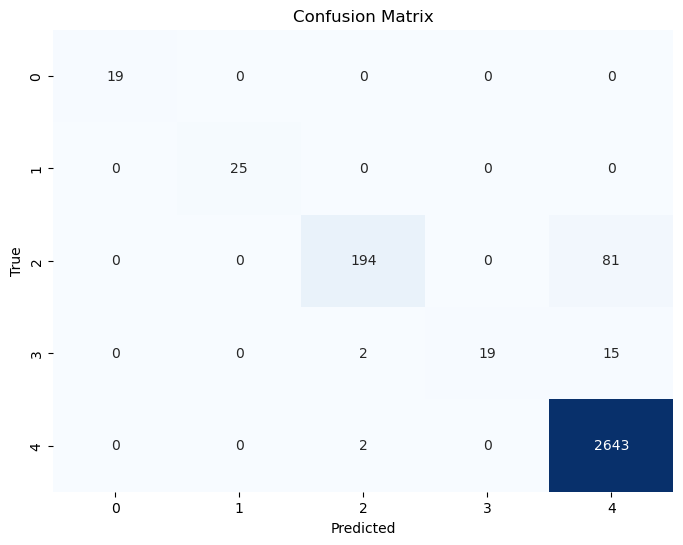

In [219]:
# 오차행렬 시각화

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 오차 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# Seaborn을 사용하여 표현
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [221]:
df_prep["label"] = labels

In [222]:
df_prep.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name,병풀잎수,메틸글루세스-20,폴리글리세린-3,병풀추출물,무화과추출물,...,에스에이치-올리 고펩타이드-1,로우스 위트블루베리추출물,솔비탄세스퀴올리에이 트,피이지-60 하이드로제네이티드캐스터오일,클로페네 신,마누카잎추출물,트라이펩타이드-3,아세틸옥타펩타이드-3,트라이펩타이드-2,label
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토...",1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,4
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청...",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트...",0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,4
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


## --- 아래는 쓰레기통 ---

kmodes 안쓸거야!

In [455]:
# Importing Libraries

from kmodes.kmodes import KModes

In [456]:
# Model Building

km_cao = KModes(n_clusters=6, init="Cao", n_init=1, verbose=1)
fitClusters_cao = km_cao.fit_predict(kmeans_clust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 581, cost: 1035133.0
Run 1, iteration: 2/100, moves: 43, cost: 1035130.0
Run 1, iteration: 3/100, moves: 0, cost: 1035130.0


In [458]:
# Predicted Clusters
fitClusters_cao

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [459]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = kmeans_clust.columns

In [462]:
# 최적의 K개수 찾기
cost = []
for num_clusters in list(range(1,8)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(kmeans_clust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1074540.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 282, cost: 1057618.0
Run 1, iteration: 2/100, moves: 0, cost: 1057618.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 337, cost: 1052461.0
Run 1, iteration: 2/100, moves: 0, cost: 1052461.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 334, cost: 1051952.0
Run 1, iteration: 2/100, moves: 0, cost: 1051952.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 330, cost: 1051678.0
Run 1, iteration: 2/100, moves: 0, cost: 1051678.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 581, cost: 1035133.0


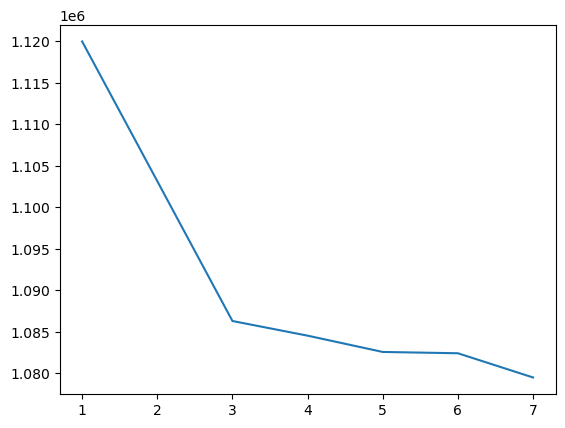

In [100]:
import numpy as np 
import matplotlib.pyplot as plt

y = np.array([i for i in range(1,8,1)])
plt.plot(y,cost)

In [ ]:
## Choosing K=5

In [101]:
km_cao = KModes(n_clusters=5, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(kmeans_clust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 655, cost: 1082585.0
Run 1, iteration: 2/100, moves: 42, cost: 1082551.0
Run 1, iteration: 3/100, moves: 1, cost: 1082551.0


In [102]:
fitClusters_cao

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)